In [3]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from Model.network import ResNet
from torchvision.io import read_image
from torchvision import transforms
import torchvision
import cv2
from Utils.draw_boxes import demonstrate_result
import torch

fake: 1
Image path: C:\Users\ANDRE\OneDrive\Desktop\Andreas_Sideras\Demokritos\Msc in AI\2nd Semester\Deep Learning\Classification and Localization of Inpainted Regions\Classification and Localization\Data\inpainted\3862_second_out.jpg
Using ResNet 18 model

 checkpoint loss: 920.9428914388021
Model's confidence about whether the image contains an artificial part: 0.9985723495483398
Model output:  tensor([  0.9986, 147.4403,  18.4397, 214.4198, 154.0730])


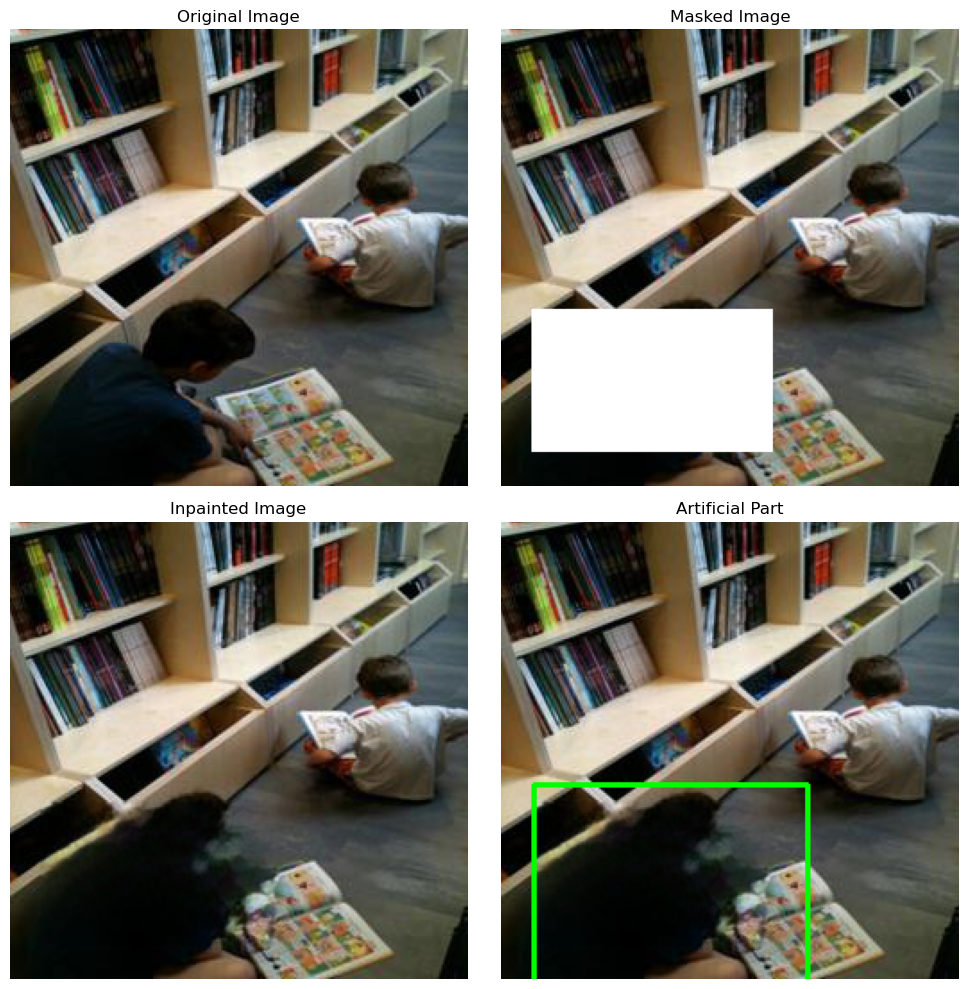

In [9]:
img_id = "3862"
demonstrate_result(img_id)

fake: 1
Image path: C:\Users\ANDRE\OneDrive\Desktop\Andreas_Sideras\Demokritos\Msc in AI\2nd Semester\Deep Learning\Classification and Localization of Inpainted Regions\Classification and Localization\Data\inpainted\9332_second_out.jpg
Using ResNet 18 model

 checkpoint loss: 920.9428914388021
Model's confidence about whether the image contains an artificial part: 0.9992177486419678
Model output:  tensor([  0.9992,  37.8502, 117.8986, 158.4282, 205.7001])


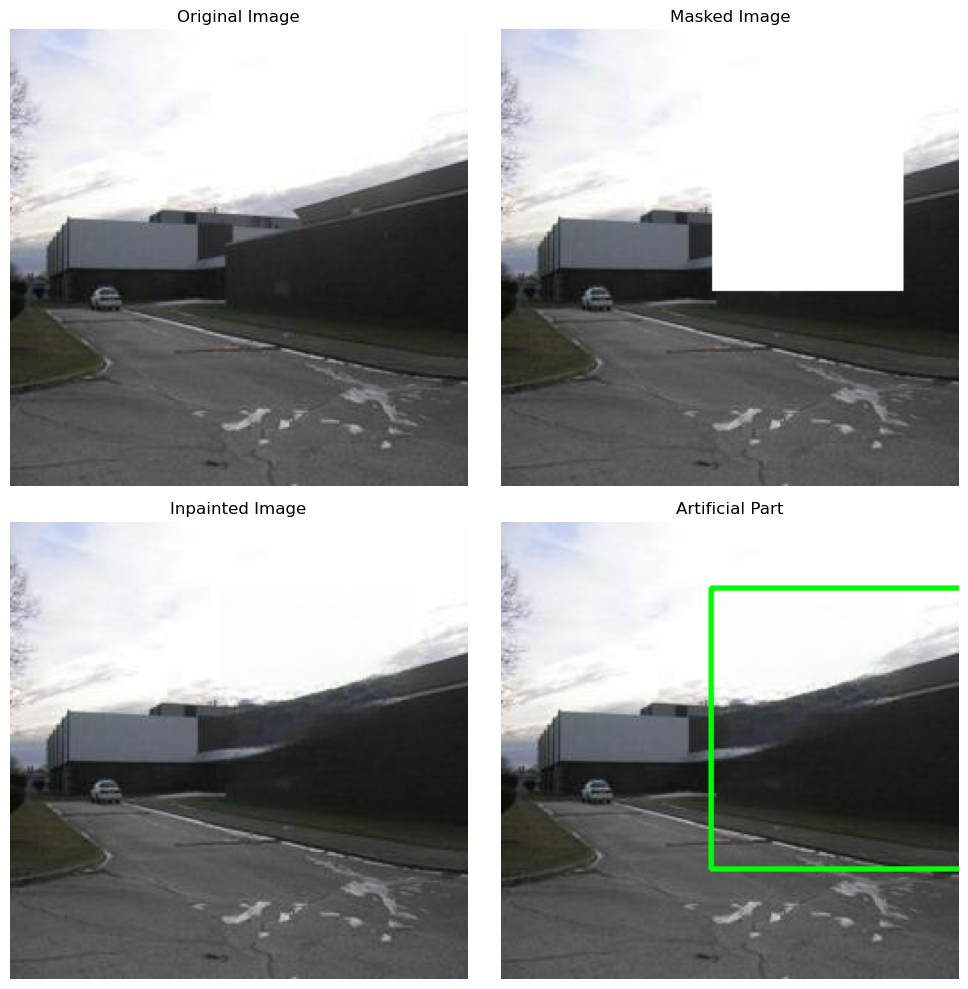

In [19]:
img_id = "9332"
demonstrate_result(img_id)

In [4]:
ground_truth_df = "C:\\Users\\ANDRE\\OneDrive\\Desktop\\Andreas_Sideras\\Demokritos\\Msc in AI\\2nd Semester\\Deep Learning\\Classification and Localization of Inpainted Regions\\Classification and Localization\\Data\\anns_class_local.csv"
test_preds_df = "C:\\Users\\ANDRE\\OneDrive\\Desktop\\Andreas_Sideras\\Demokritos\\Msc in AI\\2nd Semester\\Deep Learning\\Classification and Localization of Inpainted Regions\\Classification and Localization\\Results\\test_results.csv"
train_preds_df = "C:\\Users\\ANDRE\\OneDrive\\Desktop\\Andreas_Sideras\\Demokritos\\Msc in AI\\2nd Semester\\Deep Learning\\Classification and Localization of Inpainted Regions\\Classification and Localization\\Results\\training_results.csv"

In [5]:
ground_truth_df = pd.read_csv(ground_truth_df)
test_preds_df = pd.read_csv(test_preds_df)
train_preds_df = pd.read_csv(train_preds_df)

In [6]:
ground_truth_df

,id,fake_label,x_min,y_min,x_max,y_max
0,2792,1,154,29,238,204
1,16085,1,47,191,216,249
2,30376,0,0,0,0,0
3,33758,0,0,0,0,0
4,7342,1,189,58,245,202
...,...,...,...,...,...,...
36495,16851,1,160,4,229,126
36496,6266,1,4,50,197,187
36497,11285,1,55,50,159,145
36498,861,1,109,123,247,180


In [7]:
test_preds_df

,id,fake_label,x_min,y_min,x_max,y_max
0,24329,0.293765,0.570572,0.319845,0.774814,0.683630
1,1347,0.998717,118.217148,52.109249,192.095917,161.865875
2,18925,0.305632,0.505662,0.277941,0.694446,0.603914
3,31676,0.285737,0.705029,0.443805,0.945533,0.860154
4,1808,0.266110,1.098085,0.532418,1.311434,1.112148
...,...,...,...,...,...,...
145,5361,0.999824,32.062851,146.730560,188.507172,227.366074
146,29817,0.306778,0.460287,0.295953,0.658105,0.598475
147,2230,0.997576,103.107697,14.635184,177.910477,127.678925
148,29317,0.253362,1.326067,0.743999,1.684911,1.460011


In [74]:
train_preds_df

,id,fake_label,x_min,y_min,x_max,y_max
0,2792,0.999822,146.832581,35.646957,233.720184,187.456268
1,16085,0.999761,46.816166,180.645935,194.684967,245.727310
2,30376,0.282690,0.635858,0.363278,0.854324,0.759304
3,33758,0.288775,0.647719,0.313597,0.819314,0.692419
4,7342,0.999526,176.487183,52.331749,244.011383,195.747345
...,...,...,...,...,...,...
995,1320,0.999406,107.200500,161.390823,204.562714,235.023209
996,15579,0.999908,101.316025,161.613052,219.897430,241.429382
997,11399,0.999671,23.413933,150.718582,177.371735,231.588562
998,27178,0.319863,0.451315,0.202000,0.620045,0.512352


In [17]:

def calculate_iou(box1, box2):
    x_min1, y_min1, x_max1, y_max1 = box1
    x_min2, y_min2, x_max2, y_max2 = box2

    # Calculate the coordinates of the intersection rectangle
    x_min_intersection = max(x_min1, x_min2)
    y_min_intersection = max(y_min1, y_min2)
    x_max_intersection = min(x_max1, x_max2)
    y_max_intersection = min(y_max1, y_max2)

    # Calculate the area of the intersection rectangle
    intersection_area = max(0, x_max_intersection - x_min_intersection + 1) * max(0,
                                                                                  y_max_intersection - y_min_intersection + 1)

    # Calculate the areas of the bounding boxes
    box1_area = (x_max1 - x_min1 + 1) * (y_max1 - y_min1 + 1)
    box2_area = (x_max2 - x_min2 + 1) * (y_max2 - y_min2 + 1)

    # Calculate the Union area
    union_area = box1_area + box2_area - intersection_area

    # Calculate the IoU
    iou = intersection_area / union_area

    return iou


def accuracy(ground_truth_df, test_preds_df):
    merged_df = pd.merge(ground_truth_df, test_preds_df, on='id', how='inner', suffixes=("_ground_truth", "_pred"))

    threshold = 0.5
    actual_labels = merged_df['fake_label_ground_truth']
    predicted_values = merged_df['fake_label_pred']
    predicted_labels = np.where(predicted_values >= threshold, 1, 0)

    # Accuracy
    accuracy = accuracy_score(actual_labels, predicted_labels)

    # Precision
    precision = precision_score(actual_labels, predicted_labels)

    # Recall
    recall = recall_score(actual_labels, predicted_labels)

    # F1 score
    f1 = f1_score(actual_labels, predicted_labels)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    ground_truth_boxes = merged_df[
        ['x_min_ground_truth', 'y_min_ground_truth', 'x_max_ground_truth', 'y_max_ground_truth']]
    predicted_boxes = merged_df[['x_min_pred', 'y_min_pred', 'x_max_pred', 'y_max_pred']]

    # Define a function to calculate the IoU between two bounding boxes

    # Calculate IoU for each pair of ground truth and predicted bounding boxes
    iou_scores = []
    for i in range(len(merged_df)):
        iou = calculate_iou(ground_truth_boxes.iloc[i], predicted_boxes.iloc[i])
        iou_scores.append(iou)

    # Add the IoU scores as a new column in the dataframe
    merged_df['IoU'] = iou_scores

    contains_artificial = merged_df[merged_df['fake_label_ground_truth'] == 1]
    contains_artificial = contains_artificial[contains_artificial['fake_label_pred'] > threshold]
    # Print the dataframe with the IoU scores
    print(f"Mean IoU: {contains_artificial.IoU.mean()} ")
    return merged_df,contains_artificial

In [28]:
set(train_preds_df.id).intersection(test_preds_df.id)

set()

In [43]:
merged_df,contains_artificial = accuracy(ground_truth_df,test_preds_df)

Accuracy: 0.9466666666666667
Precision: 0.9411764705882353
Recall: 0.9411764705882353
F1 Score: 0.9411764705882353
Mean IoU: 0.6043033892721389 


In [80]:
merged_df,contains_artificial = accuracy(ground_truth_df,train_preds_df)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Mean IoU: 0.6007486822844736 


In [40]:
ground_truth_df

,id,fake_label,x_min,y_min,x_max,y_max
0,2792,1,154,29,238,204
1,16085,1,47,191,216,249
2,30376,0,0,0,0,0
3,33758,0,0,0,0,0
4,7342,1,189,58,245,202
...,...,...,...,...,...,...
36495,16851,1,160,4,229,126
36496,6266,1,4,50,197,187
36497,11285,1,55,50,159,145
36498,861,1,109,123,247,180


In [44]:
contains_artificial = merged_df[merged_df['fake_label_ground_truth'] == 1]


In [45]:
contains_artificial

,id,fake_label_ground_truth,x_min_ground_truth,y_min_ground_truth,x_max_ground_truth,y_max_ground_truth,fake_label_pred,x_min_pred,y_min_pred,x_max_pred,y_max_pred,IoU
1,1347,1,129,22,251,139,0.998717,118.217148,52.109249,192.095917,161.865875,0.328024
4,1808,1,158,48,219,118,0.266110,1.098085,0.532418,1.311434,1.112148,0.000000
8,10837,1,124,82,202,248,0.999921,118.191849,73.688576,221.650452,216.750244,0.612213
11,16202,1,111,117,229,189,0.999884,115.197281,111.524529,212.876129,207.804260,0.649971
12,6873,1,113,108,201,254,0.999922,104.078506,109.479973,214.601868,231.234528,0.689378
...,...,...,...,...,...,...,...,...,...,...,...,...
140,978,1,122,117,220,217,0.999925,119.077782,119.519585,224.513824,230.085876,0.804146
142,6396,1,85,65,212,196,0.999951,78.084488,64.118523,199.718369,190.796066,0.820573
145,5361,1,31,162,212,226,0.999824,32.062851,146.730560,188.507172,227.366074,0.708268
147,2230,1,76,3,248,113,0.997576,103.107697,14.635184,177.910477,127.678925,0.370754


In [47]:
contains_artificial[contains_artificial['fake_label_pred'] > 0.5]

,id,fake_label_ground_truth,x_min_ground_truth,y_min_ground_truth,x_max_ground_truth,y_max_ground_truth,fake_label_pred,x_min_pred,y_min_pred,x_max_pred,y_max_pred,IoU
1,1347,1,129,22,251,139,0.998717,118.217148,52.109249,192.095917,161.865875,0.328024
8,10837,1,124,82,202,248,0.999921,118.191849,73.688576,221.650452,216.750244,0.612213
11,16202,1,111,117,229,189,0.999884,115.197281,111.524529,212.876129,207.804260,0.649971
12,6873,1,113,108,201,254,0.999922,104.078506,109.479973,214.601868,231.234528,0.689378
13,18226,1,87,132,147,242,0.999013,65.351776,131.952225,168.539825,217.226013,0.500936
...,...,...,...,...,...,...,...,...,...,...,...,...
140,978,1,122,117,220,217,0.999925,119.077782,119.519585,224.513824,230.085876,0.804146
142,6396,1,85,65,212,196,0.999951,78.084488,64.118523,199.718369,190.796066,0.820573
145,5361,1,31,162,212,226,0.999824,32.062851,146.730560,188.507172,227.366074,0.708268
147,2230,1,76,3,248,113,0.997576,103.107697,14.635184,177.910477,127.678925,0.370754


In [49]:
train_preds_df.fake_label.min()

0.2431209981441497

In [55]:
no_fakes =  train_preds_df[train_preds_df.fake_label < 0.5]

In [56]:
no_fakes.mean()

id            27690.907216
fake_label        0.292456
x_min             0.697981
y_min             0.432448
x_max             0.977797
y_max             0.879364
dtype: float64

In [65]:
path = "C:\\Users\\ANDRE\\OneDrive\\Desktop\\Andreas_Sideras\\Demokritos\\Msc in AI\\2nd Semester\\Deep Learning\\Classification and Localization of Inpainted Regions\\Classification and Localization\\Data\\original\\Places365_val_00035733.jpg"

In [72]:

# Load the image using PIL
image = Image.open(path)

# Convert the image to a PyTorch tensor
transform = transforms.ToTensor()
tensor = transform(image)

# Print the shape of the tensor
print(tensor.shape)

# Repeat the tensor along the channel dimension
tensor = tensor.repeat(3, 1, 1)

# Print the shape of the repeated tensor
print(tensor.shape)

torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
